# Multi-Layer Perceptron, MNIST
---
Train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

In [1]:
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)


In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Visualize a Batch of Training Data

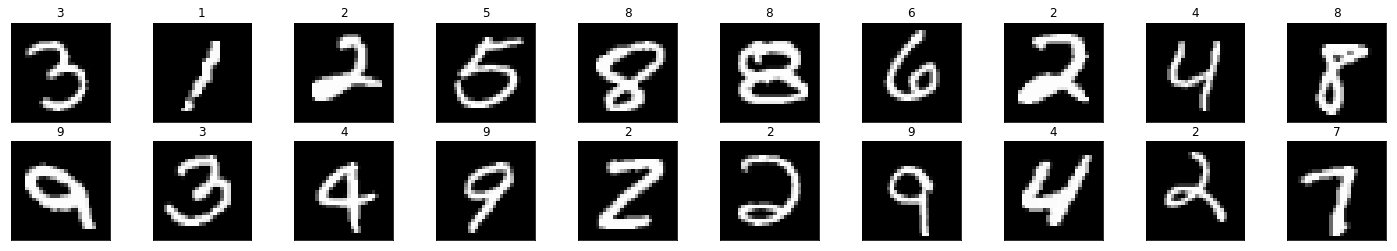

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture takes as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (number of classes) that indicates the class scores for an input image. Uses two hidden layers and dropout to avoid overfitting.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


###  [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Using cross-entropy loss for classification.

In [7]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

In [8]:
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
   
    # validate the model 
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.753320 	Validation Loss: 0.077026
Validation loss decreased (inf --> 0.077026).  Saving model ...
Epoch: 2 	Training Loss: 0.282486 	Validation Loss: 0.059425
Validation loss decreased (0.077026 --> 0.059425).  Saving model ...
Epoch: 3 	Training Loss: 0.223825 	Validation Loss: 0.048755
Validation loss decreased (0.059425 --> 0.048755).  Saving model ...
Epoch: 4 	Training Loss: 0.185427 	Validation Loss: 0.041923
Validation loss decreased (0.048755 --> 0.041923).  Saving model ...
Epoch: 5 	Training Loss: 0.156857 	Validation Loss: 0.035730
Validation loss decreased (0.041923 --> 0.035730).  Saving model ...
Epoch: 6 	Training Loss: 0.136490 	Validation Loss: 0.032479
Validation loss decreased (0.035730 --> 0.032479).  Saving model ...
Epoch: 7 	Training Loss: 0.121144 	Validation Loss: 0.029644
Validation loss decreased (0.032479 --> 0.029644).  Saving model ...
Epoch: 8 	Training Loss: 0.109397 	Validation Loss: 0.026791
Validation loss decreased (0.02964

###  Load the Model with the Lowest Validation Loss

In [9]:
model.load_state_dict(torch.load('model.pt'))

## Test the Network

In [10]:
# to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.057290

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 98% (1015/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 98% (969/982)
Test Accuracy of     5: 98% (875/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 97% (945/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 98% (9831/10000)


### Visualize Results

The text is green for accurately classified examples and red for incorrect predictions.

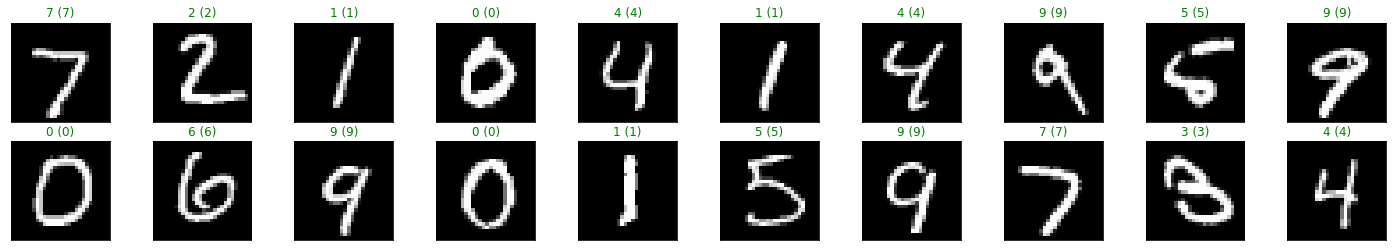

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))